In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
42011,NaN,NaN,International,2020-09-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42012,NaN,NaN,International,2020-09-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42013,NaN,NaN,International,2020-09-06,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


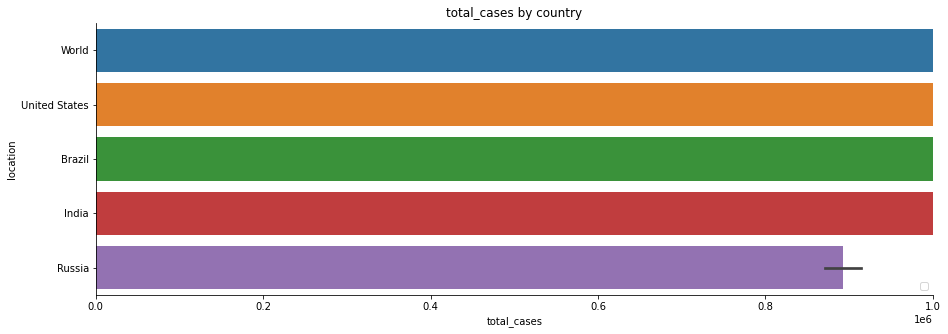

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


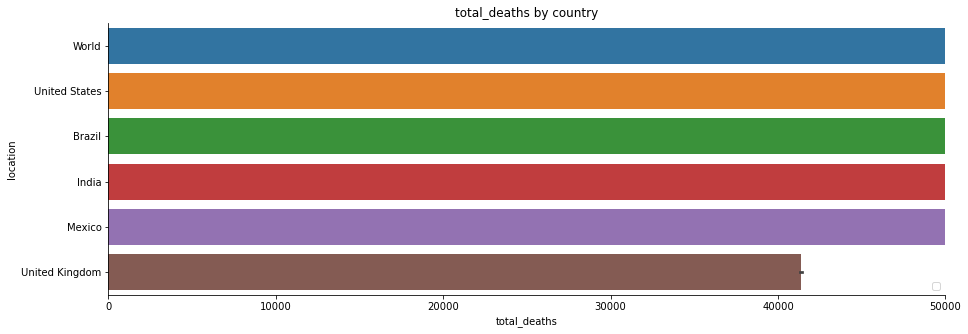

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


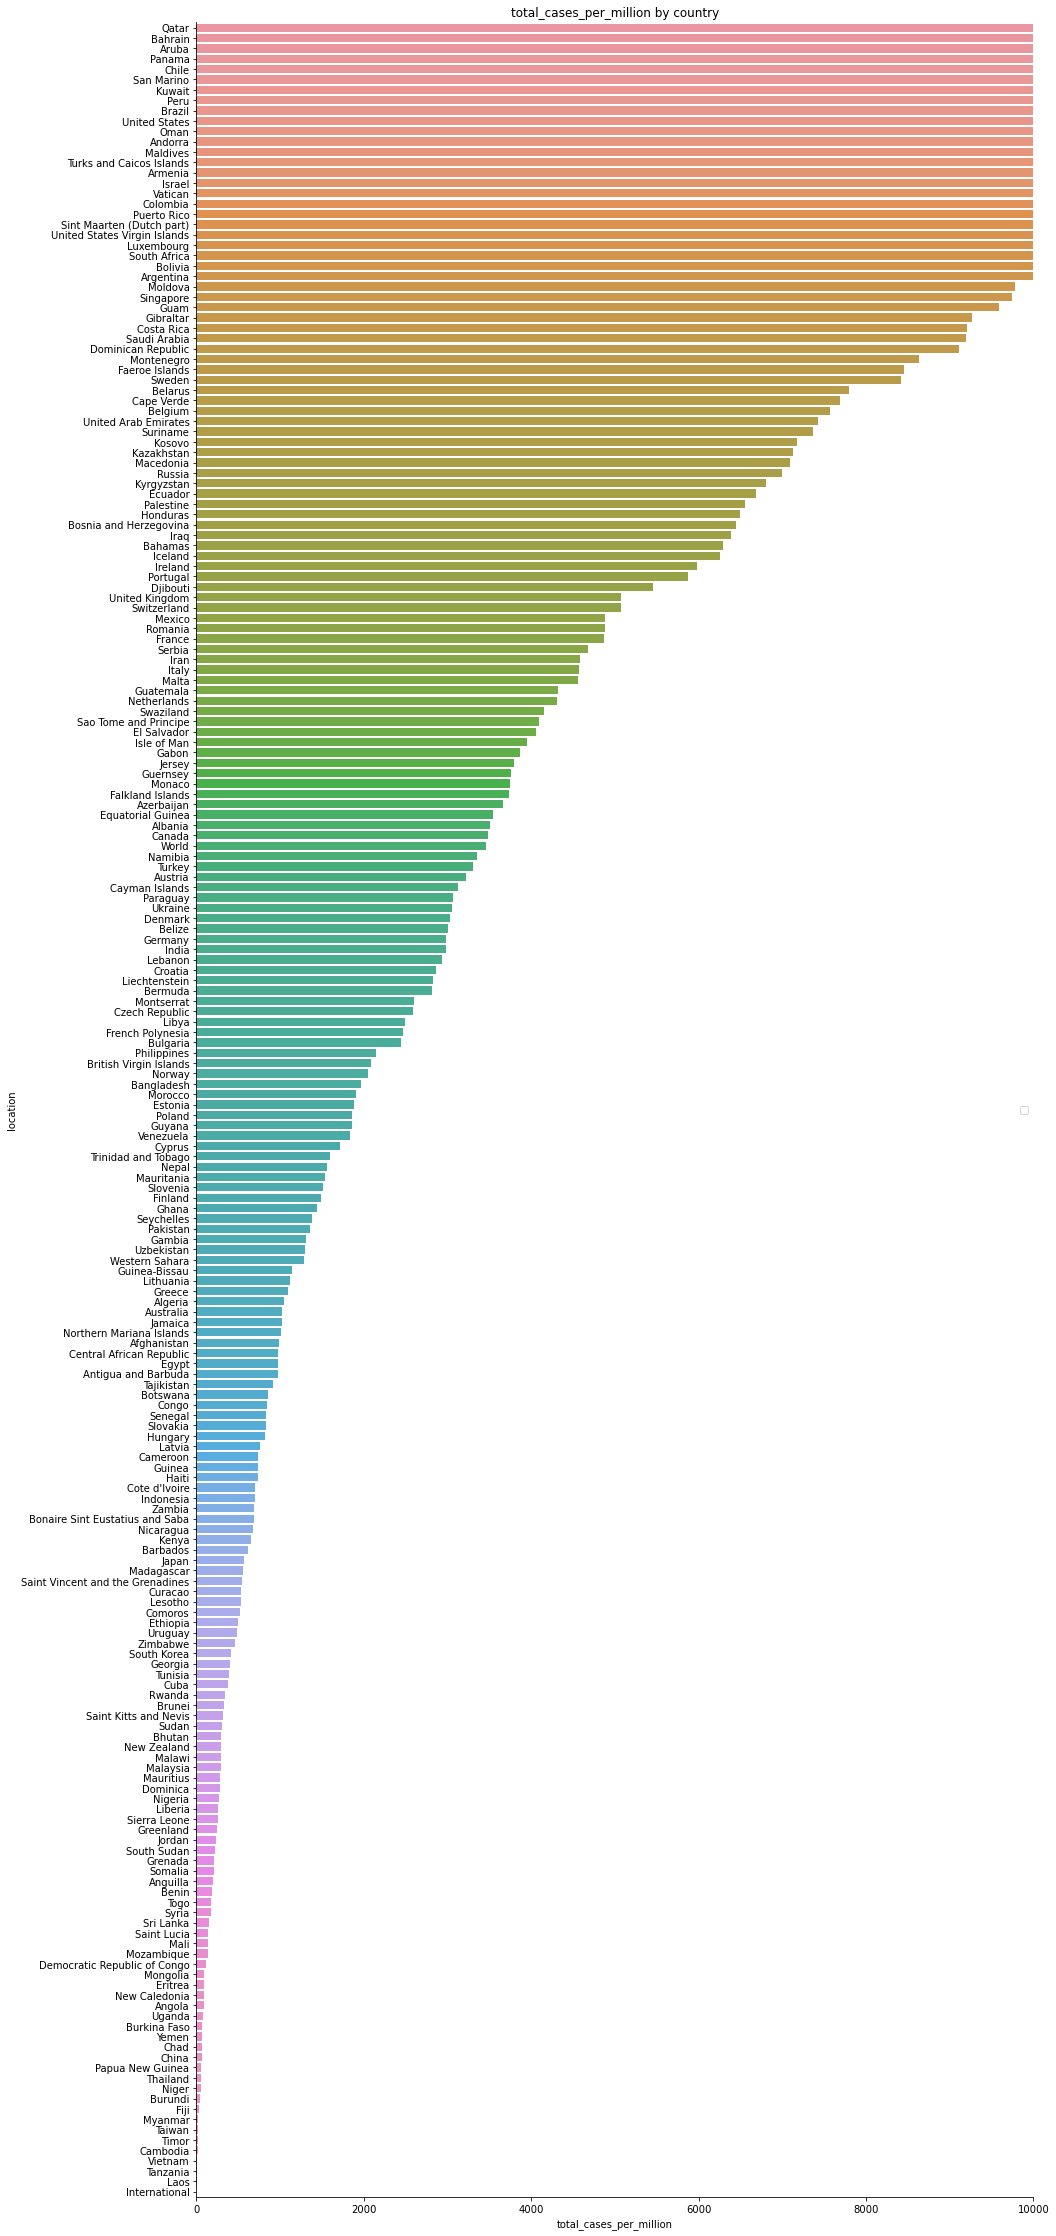

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


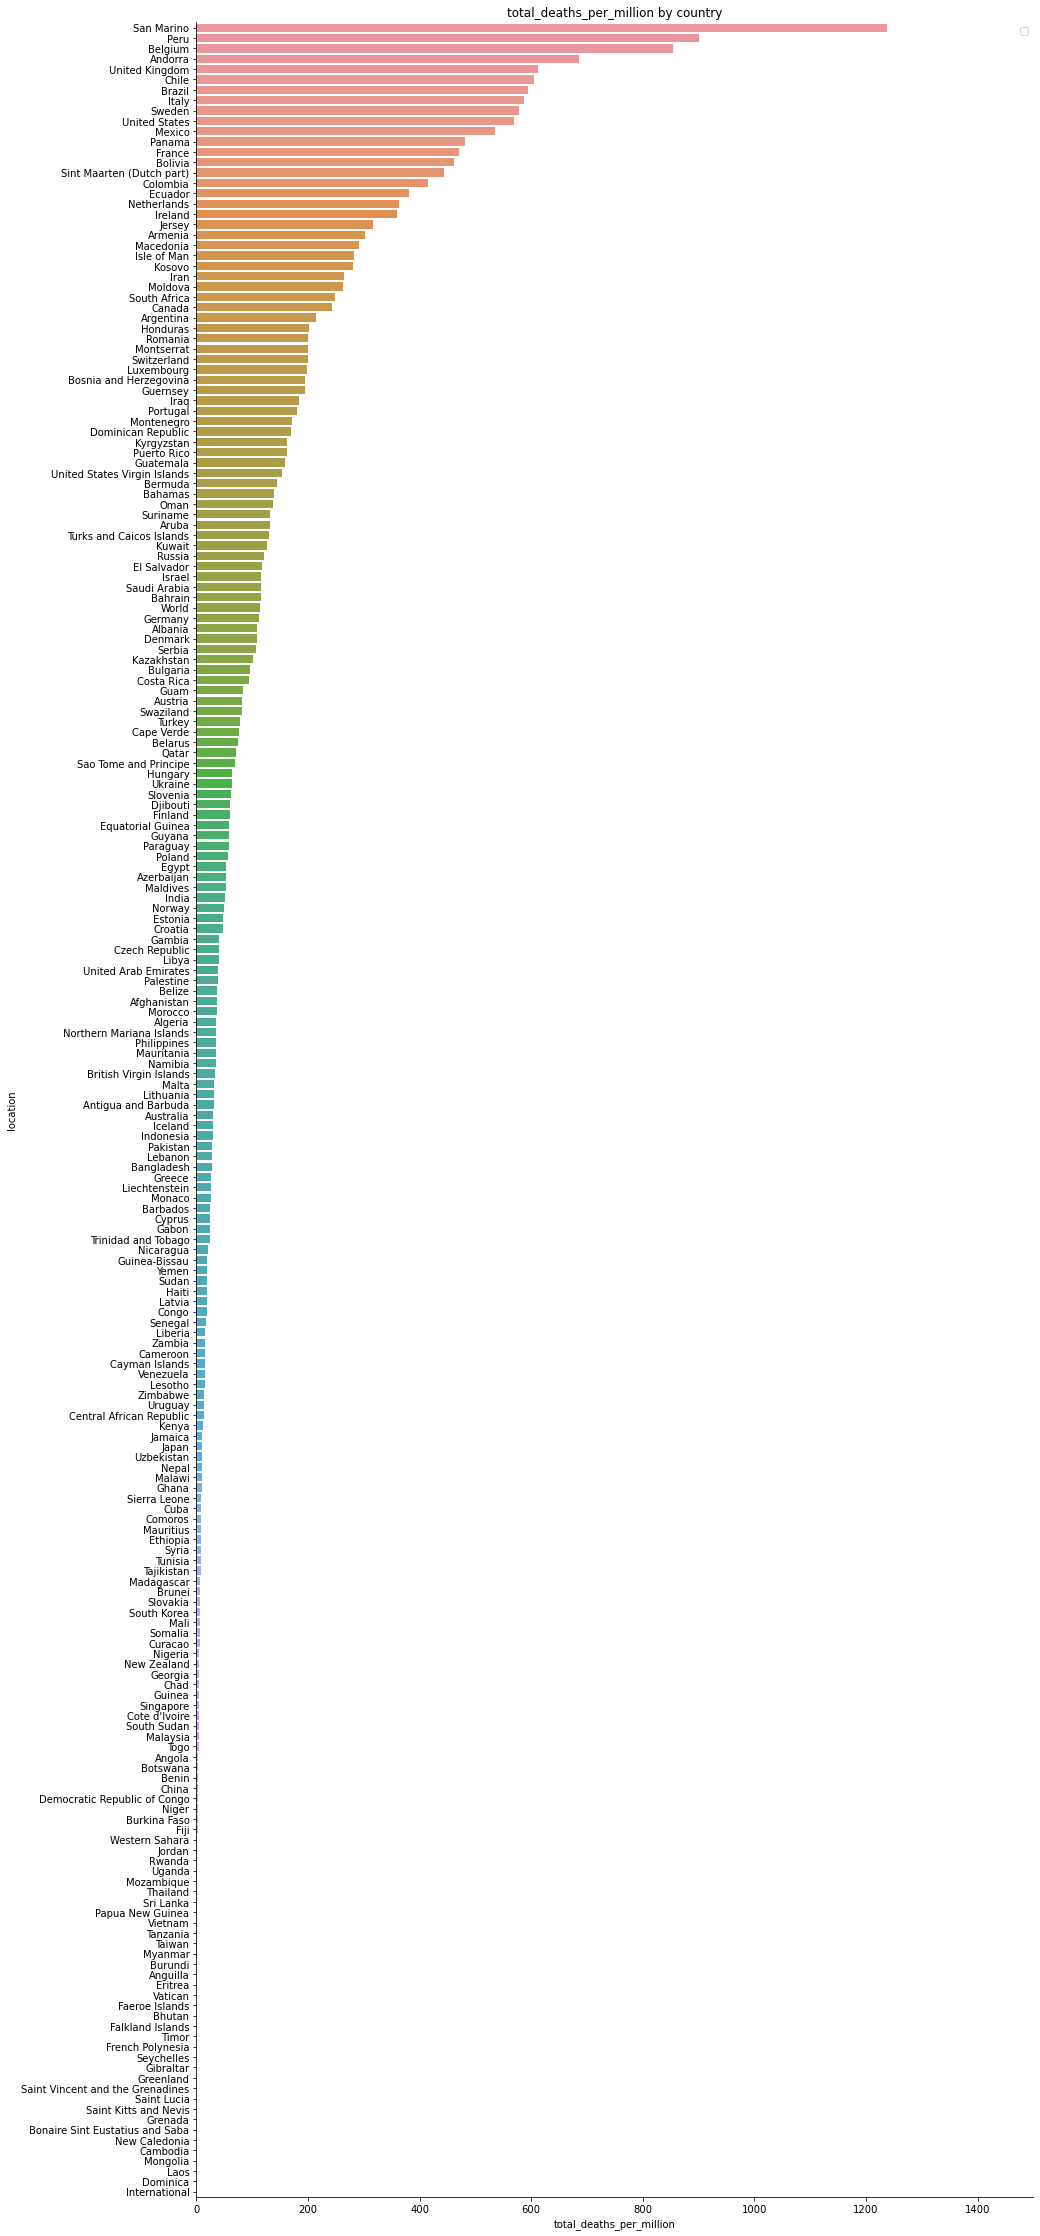

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

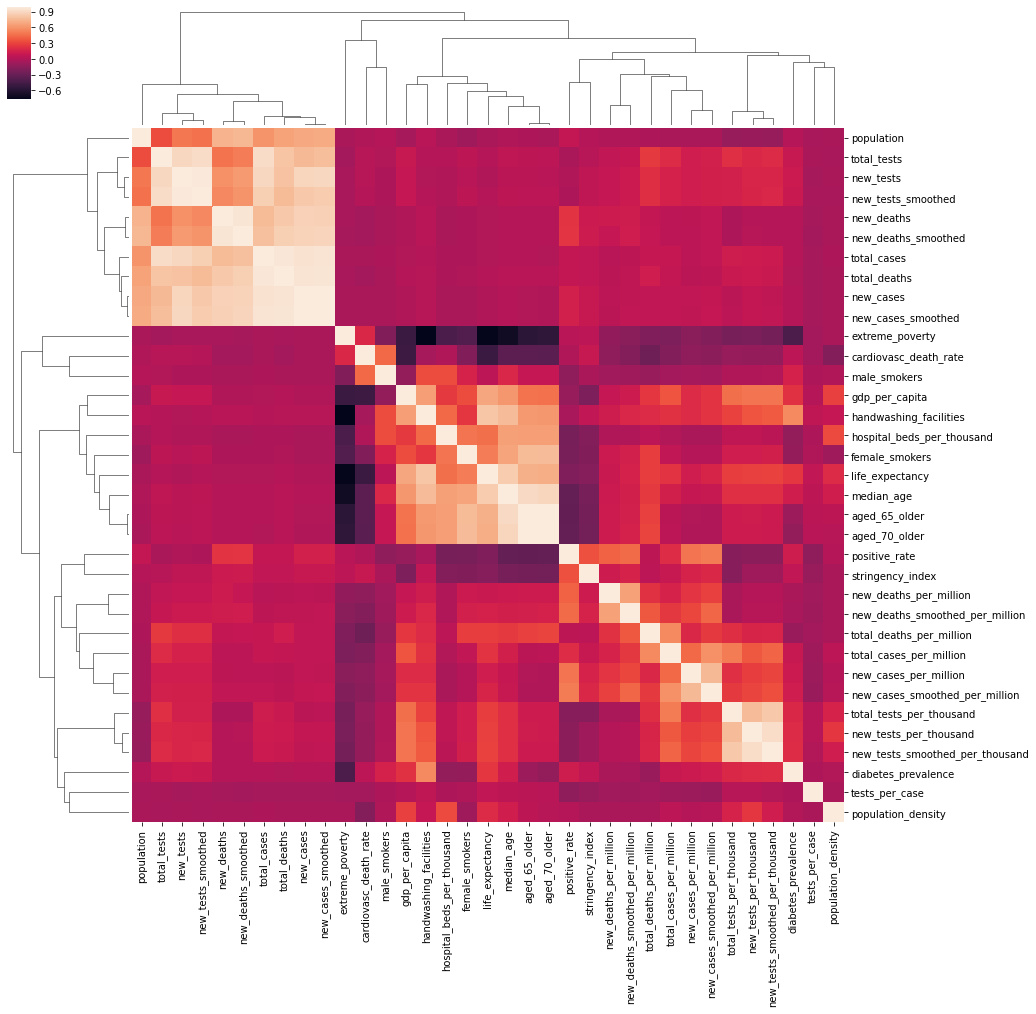

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9992040340608158 (+/- 0.000806375522006835)
Coef :  [1.03572752e+00 8.99728089e-05 9.27718162e-05]
3 Last_days :  [[26347591 26640898 26921111]]
Today :  26921111
Prediction + :  460830
Tomorow :  27381941
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996937156050496 (+/- 5.248972092674661e-05)
Coef :  [0.09560391 0.44338141 0.47126834]
3 Last_days :  [[869373 874967 881831]]
Today :  881831
Prediction + :  7581
Tomorow :  889412
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9865807520875989 (+/- 0.012288159838106116)
Coef :  [-0.74571216  0.7658299   0.98296015]
3 Last_days :  [[300181 309156 317706]]
Today :  317706
Prediction + :  7578
Tomorow :  325284
                                     
--------- Total Death -----------------
                                     
R^2: 0.39864824069076915 (+/- 0.841044829502164)
Coef :  [-0.75102122  0.78867512  0.96134681]
3 Last_days :  [[30686 30686 30698]]
Today :  30698
Prediction + :  21
Tomorow :  30719
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9254812491230746 (+/- 0.06138510271126535)
Coef :  [-0.32628479 -0.01692069  1.33747202]
3 Last_days :  [[89986 90008 90025]]
Today :  90025
Prediction + :  24
Tomorow :  90049
                                     
--------- Total Death -----------------
                                     
R^2: -139.95963845070915 (+/- 199.2239373581032)
Coef :  [-0.07716743  0.01244744  1.05657319]
3 Last_days :  [[4728 4728 4728]]
Today :  4728
Prediction + :  6
Tomorow :  4734
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8237059419895753 (+/- 0.2483560810977951)
Coef :  [-0.82404582  0.89808229  0.92531436]
3 Last_days :  [[272912 274644 276338]]
Today :  276338
Prediction + :  1508
Tomorow :  277846
                                     
--------- Total Death -----------------
                                     
R^2: 0.7553027463112175 (+/- 0.32098039077079055)
Coef :  [-0.82649152  0.89858857  0.92698942]
3 Last_days :  [[35507 35518 35534]]
Today :  35534
Prediction + :  29
Tomorow :  35563
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6386367076360416 (+/- 0.5016332274268337)
Coef :  [-0.47902177  0.31953051  1.1621185 ]
3 Last_days :  [[488513 498989 498989]]
Today :  498989
Prediction + :  6634
Tomorow :  505623
                                     
--------- Total Death -----------------
                                     
R^2: 0.007932278001338852 (+/- 1.130782436817457)
Coef :  [-0.72704182  0.63113277  1.09492903]
3 Last_days :  [[29234 29418 29418]]
Today :  29418
Prediction + :  142
Tomorow :  29560
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9861604467235581 (+/- 0.019217708148027215)
Coef :  [0.08510056 0.46261084 0.46726704]
3 Last_days :  [[6150655 6201726 6245866]]
Today :  6245866
Prediction + :  79878
Tomorow :  6325744
                                     
--------- Total Death -----------------
                                     
R^2: 0.8338590017732601 (+/- 0.2337985997432012)
Coef :  [-0.49975552  0.71422311  0.78825449]
3 Last_days :  [[186797 187765 188538]]
Today :  188538
Prediction + :  1185
Tomorow :  189723
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9135314609244795 (+/- 0.12176285193004989)
Coef :  [-0.71475306  0.84548405  0.86951585]
3 Last_days :  [[340411 342351 344164]]
Today :  344164
Prediction + :  1783
Tomorow :  345947
                                     
--------- Total Death -----------------
                                     
R^2: 0.35898888760053244 (+/- 0.8678972622129474)
Coef :  [-0.77010436  0.83147476  0.93798737]
3 Last_days :  [[41527 41537 41549]]
Today :  41549
Prediction + :  43
Tomorow :  41592
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9795732844778192 (+/- 0.026605367910457076)
Coef :  [-0.79276376  0.85573513  0.93677979]
3 Last_days :  [[246948 248997 249985]]
Today :  249985
Prediction + :  1811
Tomorow :  251796
                                     
--------- Total Death -----------------
                                     
R^2: 0.3673736450107164 (+/- 0.884609269264451)
Coef :  [-0.78966648  0.84070346  0.9482483 ]
3 Last_days :  [[9319 9324 9325]]
Today :  9325
Prediction + :  10
Tomorow :  9335
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.5335344887743887 (+/- 3.5814239448555503)
Coef :  [0.23845646 0.3869946  0.38556806]
3 Last_days :  [[380746 382772 384666]]
Today :  384666
Prediction + :  4001
Tomorow :  388667
                                     
--------- Total Death -----------------
                                     
R^2: 0.9435356194669678 (+/- 0.07926956736387107)
Coef :  [0.02640717 0.49646712 0.48845849]
3 Last_days :  [[21926 22044 22154]]
Today :  22154
Prediction + :  247
Tomorow :  22401
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999319778669316 (+/- 0.000646539683325861)
Coef :  [-0.7146113   0.83838402  0.87361218]
3 Last_days :  [[274943 276555 278228]]
Today :  278228
Prediction + :  1299
Tomorow :  279527
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991299756763995 (+/- 0.0006376001633630103)
Coef :  [-0.81108564  0.89250136  0.9160249 ]
3 Last_days :  [[6511 6564 6620]]
Today :  6620
Prediction + :  42
Tomorow :  6662
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45435542729190437 (+/- 0.767840510848971)
Coef :  [-0.09093264  0.4890094   0.61848342]
3 Last_days :  [[4041638 4092832 4123000]]
Today :  4123000
Prediction + :  68026
Tomorow :  4191026
                                     
--------- Total Death -----------------
                                     
R^2: 0.4884444101357765 (+/- 0.7217369600509045)
Coef :  [-0.08162854  0.50619339  0.5876321 ]
3 Last_days :  [[124614 125521 126203]]
Today :  126203
Prediction + :  1606
Tomorow :  127809
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(26921111, 881831, 27381941, 889412),
 (317706, 30698, 325284, 30719),
 (276338, 35534, 277846, 35563),
 (498989, 29418, 505623, 29560),
 (6245866, 188538, 6325744, 189723),
 (90025, 4728, 90049, 4734),
 (344164, 41549, 345947, 41592),
 (249985, 9325, 251796, 9335),
 (384666, 22154, 388667, 22401),
 (278228, 6620, 279527, 6662),
 (4123000, 126203, 4191026, 127809)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-06,France,325284.0,0.0,30719.0,0.0,0.0,0.0
0,2020-09-06,China,90049.0,0.0,4734.0,0.0,0.0,0.0
0,2020-09-06,Italy,277846.0,0.0,35563.0,0.0,0.0,0.0
0,2020-09-06,Spain,505623.0,0.0,29560.0,0.0,0.0,0.0
0,2020-09-06,United States,6325744.0,0.0,189723.0,0.0,0.0,0.0
0,2020-09-06,World,27381941.0,0.0,889412.0,0.0,0.0,0.0
0,2020-09-06,United Kingdom,345947.0,0.0,41592.0,0.0,0.0,0.0
0,2020-09-06,Germany,251796.0,0.0,9335.0,0.0,0.0,0.0
0,2020-09-06,Iran,388667.0,0.0,22401.0,0.0,0.0,0.0
0,2020-09-06,Turkey,279527.0,0.0,6662.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")